In [1]:
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
import os

from main import *
from model import *

%load_ext autoreload
%autoreload 2

In [2]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

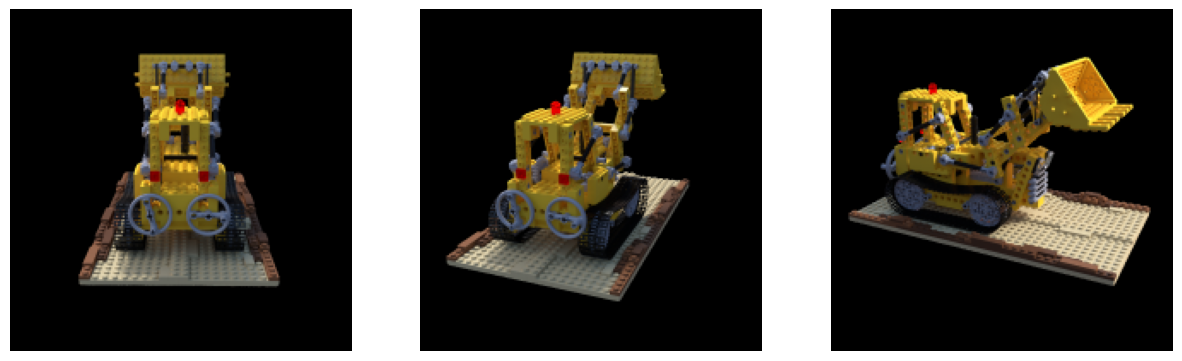

In [3]:
# show 2-3 random images
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].imshow(images_train[i])
    ax[i].axis('off')

In [4]:
batch_size = 10_000
train_dataset = RayDataset(images_train, c2ws_train, focal)
val_dataset = RayDataset(images_val, c2ws_val, focal)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
model = Net3d(device)
print(model)

Net3d(
  (pe_x): PositionalEncoding()
  (pe_rd): PositionalEncoding()
  (mlp1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (mlp2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (density_head): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): ReLU()
  )
  (pre_mix_head): Linear(in_features=256, out_features=256, bias=True)
  (color_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)


In [7]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)

In [8]:
loss_list = []
PSNR_list = []

val_loss_list = []
val_PSNR_list = []

def train(model, loss_fn, optimizer):
    
    for i in range(len(train_dataset) // batch_size):
        rays_o, rays_d, rgb_gt = train_dataset.sample_rays(batch_size)
        x = train_dataset.sample_along_rays(rays_o, rays_d, perturb=True) # N x n_samples x 3
        rays_d = rays_d.unsqueeze(1).repeat(1, x.shape[1], 1)  # N x n_samples x 3

        optimizer.zero_grad()
        rgb, density = model(x, rays_d)
        rgb_pred = volrender(density, rgb, (6.0 - 2.0) / 64, device)
        
        loss = loss_fn(rgb_pred, rgb_gt.to(device))
        loss_list.append(loss.item())
        PSNR_list.append(PSNR(loss).item())

        loss.backward()
        optimizer.step()

        # do validation inference
        if (i + 1) % 25 == 0:
            model.eval()
            with torch.no_grad():
                rays_o, rays_d, rgb_gt = val_dataset.sample_rays(batch_size)
                x = val_dataset.sample_along_rays(rays_o, rays_d)
                rays_d = rays_d.unsqueeze(1).repeat(1, x.shape[1], 1)
        
                rgb, density = model(x, rays_d)
                rgb_pred = volrender(density, rgb, (6.0 - 2.0) / 64, device)
        
                val_loss = loss_fn(rgb_pred, rgb_gt.to(device))
                val_loss_list.append(val_loss.item())
                val_PSNR_list.append(PSNR(val_loss).item())

                print(f'Batch {i}, Loss: {loss.item()}, PSNR: {PSNR(loss).item()}, Val Loss: {val_loss.item()}, Val PSNR: {PSNR(val_loss).item()}')
            model.train()

        if i % 10 == 0:
            print(f'Batch {i}, Loss: {loss.item()}, PSNR: {PSNR(loss).item()}')

In [9]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(model, loss_fn, optimizer)

Epoch 1
-------------------------------
Batch 0, Loss: 0.07751381397247314, PSNR: 11.106209754943848
Batch 10, Loss: 0.06621276587247849, PSNR: 11.790582656860352
Batch 20, Loss: 0.06322645395994186, PSNR: 11.991012573242188
Batch 24, Loss: 0.061981916427612305, PSNR: 12.077350616455078, Val Loss: 0.055676236748695374, Val PSNR: 12.543301582336426
Batch 30, Loss: 0.06180467829108238, PSNR: 12.089786529541016
Batch 40, Loss: 0.05703578516840935, PSNR: 12.438526153564453
Batch 49, Loss: 0.05218273028731346, PSNR: 12.824731826782227, Val Loss: 0.04782118275761604, Val PSNR: 13.203797340393066
Batch 50, Loss: 0.05302264168858528, PSNR: 12.755386352539062
Batch 60, Loss: 0.041577816009521484, PSNR: 13.811384201049805
Batch 70, Loss: 0.02955053374171257, PSNR: 15.294346809387207
Batch 74, Loss: 0.02411150000989437, PSNR: 16.177757263183594, Val Loss: 0.019207555800676346, Val PSNR: 17.165279388427734
Batch 80, Loss: 0.035890936851501465, PSNR: 14.450153350830078
Batch 90, Loss: 0.01896521449

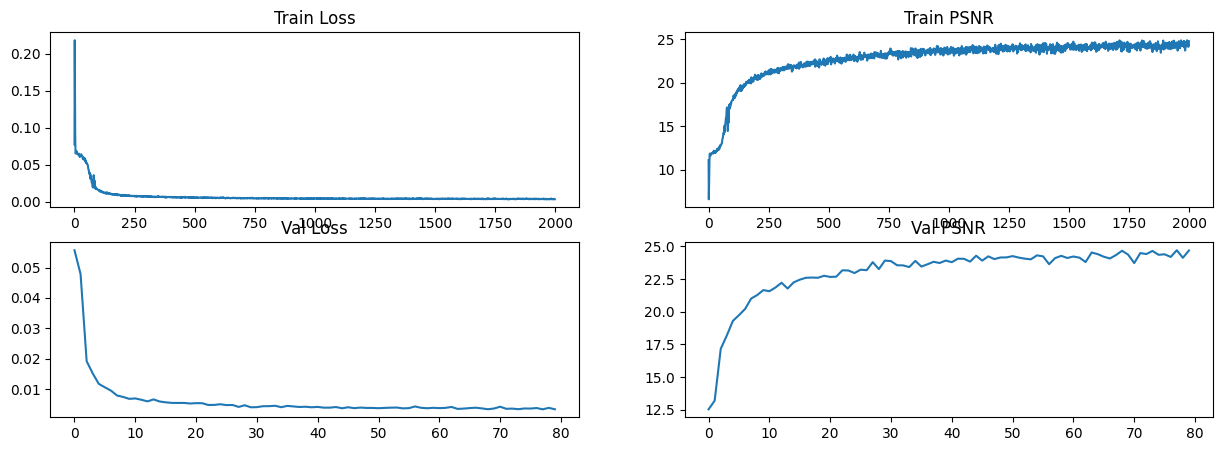

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].plot(loss_list)
ax[0, 0].set_title('Train Loss')

ax[0, 1].plot(PSNR_list)
ax[0, 1].set_title('Train PSNR')

ax[1, 0].plot(val_loss_list)
ax[1, 0].set_title('Val Loss')

ax[1, 1].plot(val_PSNR_list)
ax[1, 1].set_title('Val PSNR')

plt.show()

In [45]:
# get current time for saving model
import datetime
now = datetime.datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M")

# create a new folder for the model in the trained_models folder
os.makedirs(f"./trained_models/model_{now}")

# save the model
torch.save(model.state_dict(), f"./trained_models/model_{now}/model.pt")

# also save the loss and PSNR graphs all on different graphs but same figure
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(loss_list)
ax[0, 0].set_title('Train Loss')

ax[0, 1].plot(PSNR_list)
ax[0, 1].set_title('Train PSNR')

ax[1, 0].plot(val_loss_list)
ax[1, 0].set_title('Val Loss')

ax[1, 1].plot(val_PSNR_list)
ax[1, 1].set_title('Val PSNR')

plt.savefig(f"./trained_models/model_{now}/loss_psnr.png")
plt.close()

In [11]:
K = train_dataset.K.to('cpu')
c2w_curr = torch.from_numpy(c2ws_val[0]).to(torch.float32).to('cpu')
im = get_scene_image(model, c2w_curr, K, 'cpu')
im.shape

/home/aviral/miniconda3/envs/nerf-env/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([200, 200, 3])

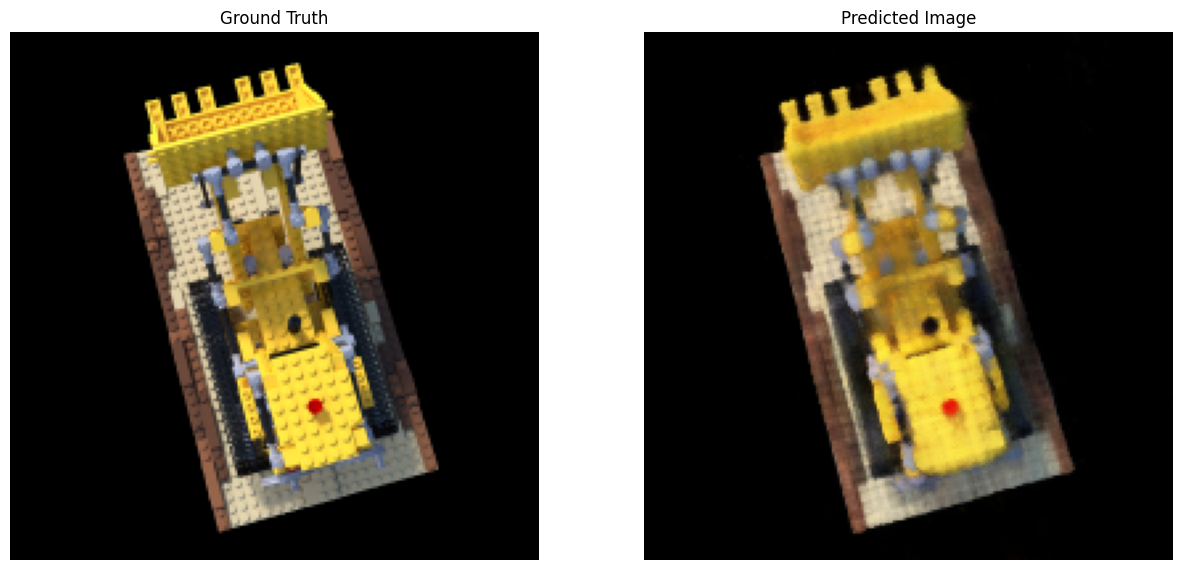

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(images_val[0])
ax[0].axis('off')
ax[0].set_title('Ground Truth')

ax[1].imshow(im.detach().cpu().numpy())
ax[1].axis('off')
ax[1].set_title('Predicted Image')

plt.show()

In [21]:
get_gif(model, c2ws_test, K, 'cpu', 'lego.gif')